# Bolometric modeling of GW170817

## Imports

In [1]:
from astropy.table import join, Table
from astropy.time import Time
from astropy import units as u
from astropy.utils.data import download_file
from ligo.gracedb.rest import GraceDb
from lxml import etree
import seaborn

## Merger time

LIGO/Virgo merger time in UTC from [GCN 21513](https://gcn.gsfc.nasa.gov/gcn3/21513.gcn3).

In [2]:
t0 = Time(1187008882.443, format='gps').utc
t0.iso

'2017-08-17 12:41:04.443'

## GW170817 photometry

Retrieve the light curve from the [Open Kilonova Catalog](https://kilonova.space).

In [3]:
url = 'https://api.kilonova.space/GW170817/photometry/system+upperlimit+time+band+magnitude+e_magnitude?format=csv'
photometry = Table.read(url, format='ascii')

# Keep only data points that are in the AB magnitude system.
photometry = photometry[photometry.columns.pop('system') == 'AB']

# Keep only detections (no upper limits).
photometry = photometry[photometry.columns.pop('upperlimit') == 'F']

# Get rid of unfiltered observations (mostly MASTER).
photometry = photometry[photometry['band'] != 'C']
photometry = photometry[photometry['band'] != 'W']

# Convert to time since merger.
photometry['time'] = (np.asarray(photometry.columns.pop('time')).astype(float) - t0.mjd) * u.day

photometry

band,magnitude,e_magnitude,time
,,,d
str5,float64,float64,float64
i,17.48,0.02,0.45287635416
H,18.26,0.15,0.461676354164
r,17.46,0.03,0.464476354166
Ks,18.62,0.05,0.470476354167
J,17.83,0.15,0.471476354163
V,17.35,0.02,0.471476354163
r,17.33,0.02,0.471476354163
z,17.67,0.03,0.471476354163


## Get filter wavelengths.

Retrieve filter wavelengths from the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps/).

**TODO**: Double check these.

In [4]:
filter_longnames = {
    'F110W': 'HST/WFC3_IR.F110W',
    'F160W': 'HST/WFC3_IR.F160W',
    'F336W': 'HST/WFC3_UVIS2.F336W',
    'F475W': 'HST/WFC3_UVIS2.F475W',
    'F606W': 'HST/WFC3_UVIS2.F606W',
    'F625W': 'HST/WFC3_UVIS2.F625W',
    'F775W': 'HST/WFC3_UVIS2.F775W',
    'F814W': 'HST/WFC3_UVIS2.F814W',
    'F850W': 'HST/WFC3_UVIS2.F850LP',
    'B': 'Swift/UVOT.B',
    'U': 'Swift/UVOT.U',
    'V': 'Swift/UVOT.V',
    'W1': 'Swift/UVOT.UVW1',
    'W2': 'Swift/UVOT.UVW2',
    'M2': 'Swift/UVOT.UVM2',
    'H': 'Gemini/Flamingos2.H',
    'I': 'CTIO/DECam.I',
    'Y': 'CTIO/DECam.Y',
    'R': 'CTIO/DECam.R',
    'J': 'Gemini/Flamingos2.J',
    'K': 'Gemini/Flamingos2.Ks',
    'Ks': 'Gemini/Flamingos2.Ks',
    'u': 'SLOAN/SDSS.u',
    'g': 'SLOAN/SDSS.g',
    'r': 'SLOAN/SDSS.r',
    'i': 'SLOAN/SDSS.i',
    'z': 'SLOAN/SDSS.z',
    'y': 'PAN-STARRS/PS1.y',
    'J1': 'LCO/FourStar.J1',
    'w': 'LasCumbres/LasCumbres.PS_w'
}
filter_names = []
filter_wavelengths = []
pattern = 'http://svo2.cab.inta-csic.es/svo/theory/fps3/fps.php?PhotCalID={}/AB&VERB=2'
for name, longname in filter_longnames.items():
    filename = download_file(pattern.format(longname), cache=True)
    tree = etree.parse(filename)
    elem, = tree.iterfind(
        '//{*}PARAM[@name="WavelengthCen"][@unit="Angstrom"]')
    filter_names.append(name)
    filter_wavelengths.append(float(elem.attrib['value']))
filters = Table([filter_names, np.asarray(filter_wavelengths) * u.Angstrom], names=['band', 'wavelength'])
filters.sort('wavelength')
filters

band,wavelength
,Angstrom
str5,float64
W2,1941.22132174
M2,2246.00356226
W1,2604.56916481
F336W,3368.34066118
U,3463.14480935
u,3565.05466331
B,4371.22288257
g,4700.32922202


## Plot light curve

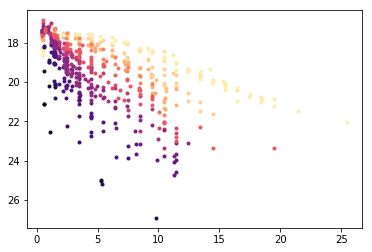

In [5]:
ax = plt.axes()
ax.invert_yaxis()
palette = dict(zip(filters['band'], seaborn.color_palette('magma', len(filters))))
for group in photometry.group_by('band').groups:
    band = group[0]['band']
    ax.plot(group['time'], group['magnitude'], '.', color=palette[band])